## <font color='darkred'> Inteligência Artificial em Finanças </font>
    
### <font color='darkgreen'>Lab 1 - Parte 2 - Modelo ARIMA</font>

### <font color='darkblue'>Forecast de títulos de Renda Fixa ao longo do tempo</font>

### <font color='darkblue'>Instalando e Carregando Pacotes</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 12
m.rcParams['xtick.labelsize'] = 10
m.rcParams['ytick.labelsize'] = 10
m.rcParams['text.color'] = 'k'

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Michelle Bouhid" --iversions

Author: Michelle Bouhid

pandas     : 1.5.3
sklearn    : 1.3.0
numpy      : 1.23.5
matplotlib : 3.7.1
statsmodels: 0.14.0
platform   : 1.0.8



### <font color='darkblue'>Carregando Dados</font>

In [5]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

In [6]:
# Converte a coluna data para o tipo correto
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [7]:
# Converte a coluna data para o tipo correto
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [8]:
# Vamos extrair os detalhes da coluna data: ano, mês, dia e hora
for i in (dados_treino, dados_teste):
    i['ano'] = i.data.dt.year
    i['mes'] = i.data.dt.month
    i['dia'] = i.data.dt.day
    i['hora'] = i.data.dt.hour

In [9]:
# Precisamos do dia da semana também
dados_treino['dia_semana'] = dados_treino['data'].dt.dayofweek

In [10]:
# Vejamos como ficou o dataset
dados_treino.head()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
0,0,2020-08-25 00:00:00,8,2020,8,25,0,1
1,1,2020-08-25 01:00:00,2,2020,8,25,1,1
2,2,2020-08-25 02:00:00,6,2020,8,25,2,1
3,3,2020-08-25 03:00:00,2,2020,8,25,3,1
4,4,2020-08-25 04:00:00,2,2020,8,25,4,1


In [11]:
# Refinamos os dados para o gráfico da série original

# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

# Removemos a coluna ID, pois ela não é relevante neste caso
features = dados_treino.drop('id', axis = 1)

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dados_treino['valor_titulo']

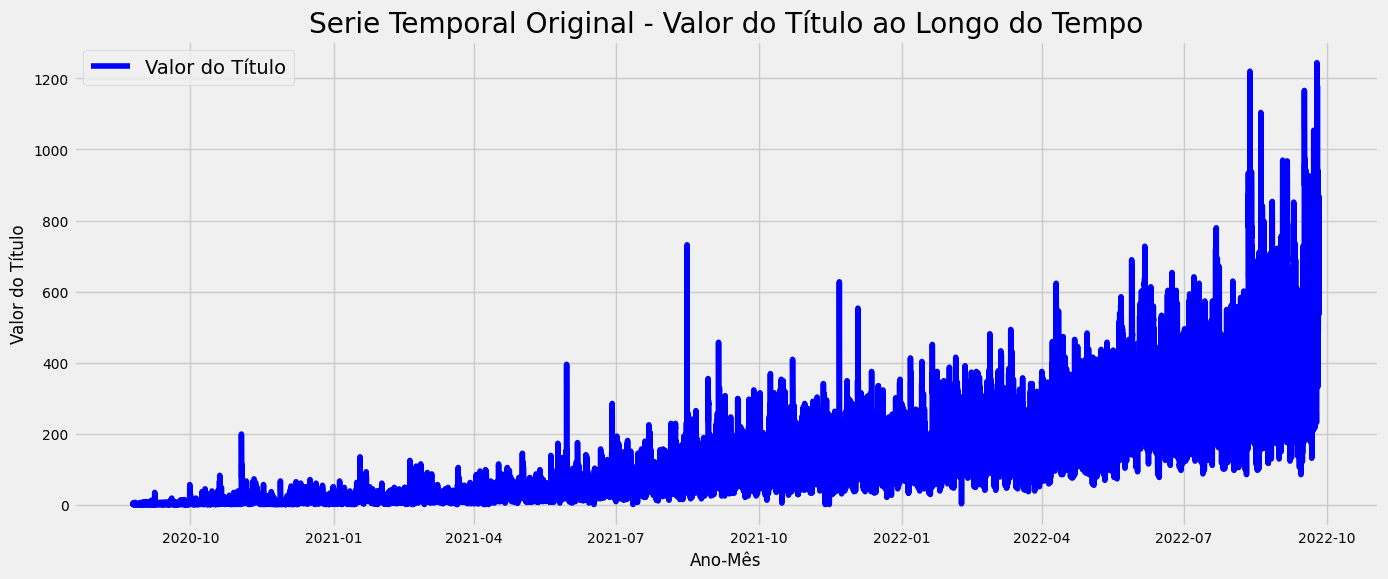

In [12]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Valor do Título ao Longo do Tempo")
plt.plot(target, label = "Valor do Título", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Valor do Título")
plt.legend(loc = "best")

### <font color='darkblue'>Pré-Processamento</font>

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [13]:
# Os dados de treino serão divididos em dados de treino e validação.
# Observe que os registros são separados em ordem cronológica.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [14]:
df_treino.shape

(16057, 8)

In [15]:
df_valid.shape

(2230, 8)

Na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). 

Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

> A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). 

> A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. 

> O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus  valores  e  os  valores  anteriores  (e  esse  processo  de  diferenciação  pode  ter  sido executado mais de uma vez). 

O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível. 

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Quando  dois  dos  três  termos  são  zeros,  o  modelo  pode  ser  referido  com  base  no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. 

Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1). 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado em termos da média móvel da parte sazonal do modelo ARIMA.

**Para Modelos ARIMA devemos remover a tendência.**

> Sequência para remover a Tendência:

- 1 - Transformação log
- 2 - Calculo da Média Movel
- 3 - Aplica diferenciação

Na suavização exponencial não precisou porque a técnica ja tem esse efeito qdo dá mais peso aos dados mais recentes

In [16]:
# Aplicando transformação de log
df_treino_log = np.log(df_treino['valor_titulo']) 

In [17]:
# Calculando a Moving Average (Média Móvel) - usa para difenciação
media_movel = df_treino_log.rolling(24).mean() 

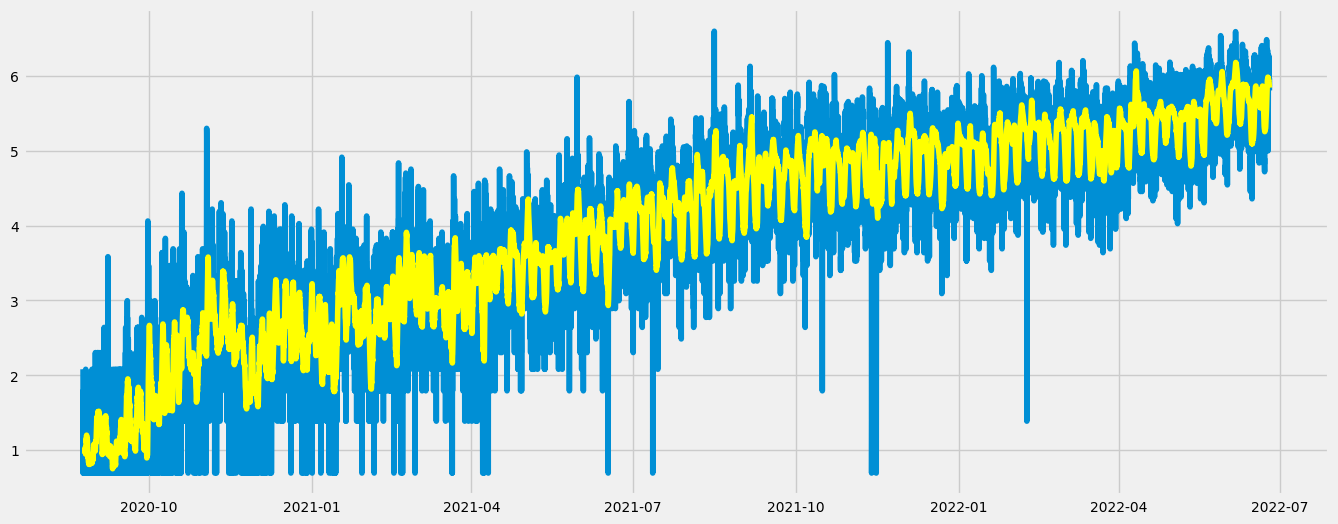

In [18]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log) 
plt.plot(media_movel, color = 'yellow') 
plt.show()

In [19]:
# Diferenciação
# Subtrai da série temporal a media movel e grava em outro dataset
df_treino_media_movel_diff = df_treino_log - media_movel
df_treino_media_movel_diff.dropna(inplace = True)  #lembrar de remover NA

In [20]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    figure(figsize = (15, 6))
    orig = plt.plot(serie, color = 'green', label = 'Original')
    mean = plt.plot(rolmean, color = 'orange', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'blue', label = 'Desvio Padrão')
    
    # Gráfico
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

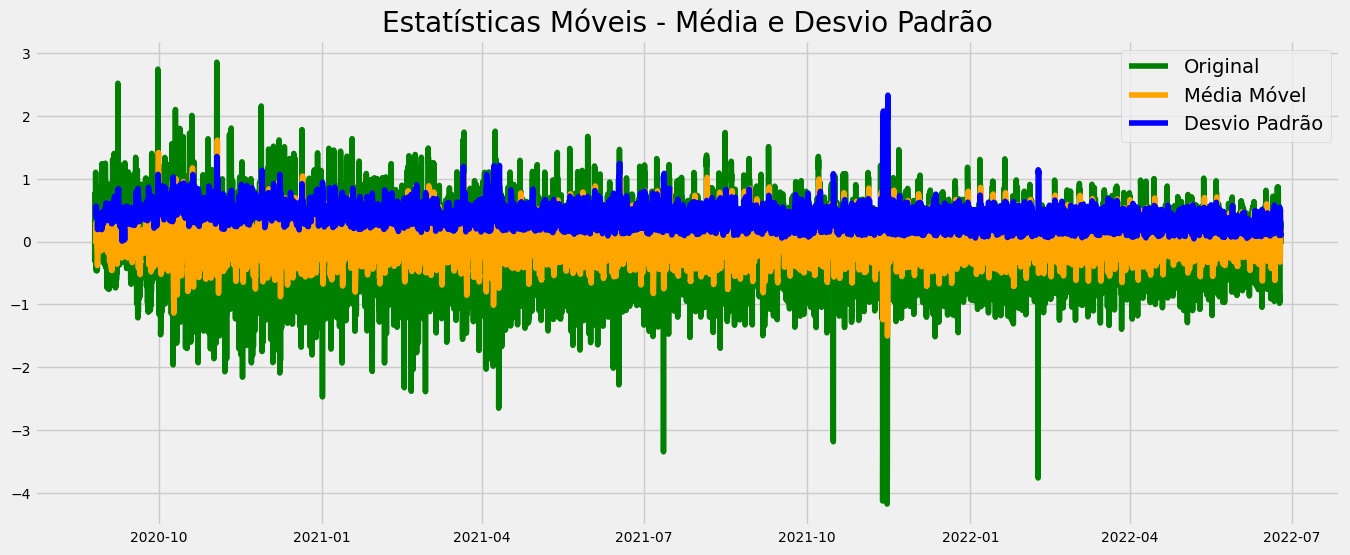


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -22.471885
Valor-p                             0.000000
Número de Lags Consideradas        43.000000
Número de Observações Usadas    15990.000000
Valor Crítico (1%)                 -3.430759
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [21]:
# Aplica a função para checar a estacionaridade
testa_estacionaridade(df_treino_media_movel_diff)

## <font color = 'darkred'> Forecasting - Modelagem Preditiva Para Séries Temporais </font>

### <font color='darkblue'> Implementando a Estratégia 3 de Forecasting - Modelo ARIMA</font>

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [22]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2 define qtos valores anteriores olhar para prever o proximo valor
# d = 1 porque fez 1 diferenciação
# q = 1 usou 1 media movel

# só faz a diferenciação pra achar os parametros da função, mas usa o conjunto de dados antes de diferenciar!

# Modelo
# Usa log pq um dos requisitos do modelo é que os dados estejam na mesma escala, por isso o df log
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 1), freq = 'H') # frequencia = hora

Parâmetro order = (2, 1, 1): Esses são os parâmetros do modelo ARIMA.

O primeiro número, 2, é a parte "AR" ou autoregressiva do modelo. Isso significa que o modelo considerará os dois valores anteriores da série temporal para fazer uma previsão.

O segundo número, 1, é a parte "I" ou integrada do modelo. Isso se refere ao número de vezes que a série temporal é diferenciada para tornar a série estacionária (ou seja, os dados têm uma média e variância constantes ao longo do tempo). Neste caso, os dados são diferenciados uma vez.

O último número, 1, é a parte "MA" ou média móvel do modelo. Este número indica que o modelo irá considerar o erro da previsão do último período na previsão do próximo período.

**ATENÇÃO**:

Você pode estar se perguntando: Mas por que usamos os dados originais (com a transformação de log) para criar o modelo? Não deveríamos usar a série diferenciada? 

De forma bem clara e objetiva, a resposta é: **Não**. 

Realizamos uma ou mais etapas de diferenciação para descobrir os coeficientes do modelo ARIMA. 

'I' no ARIMA significa Integração, que leva em consideração o número de dados diferenciados necessários para se tornar a série estacionária. 

Realizamos essas etapas de diferenciação no início para encontra o valor ideal de "I" (ou seja, o Modelo ARIMA faz todo o trabalho).

**A diferenciação que aplicamos na série temporal foi para encontrar os melhores valores de p, d e q que colocamos aqui: order = (2, 1, 1).**

Portanto, treinamos o modelo ARIMA com TODOS os dados, a série inteira (dados de treino). 

In [23]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [24]:
# Dados reais e previsões nos dados de treino
dados_reais = df_treino_log
previsoes = modelo_v3.fittedvalues # previsoes em treino

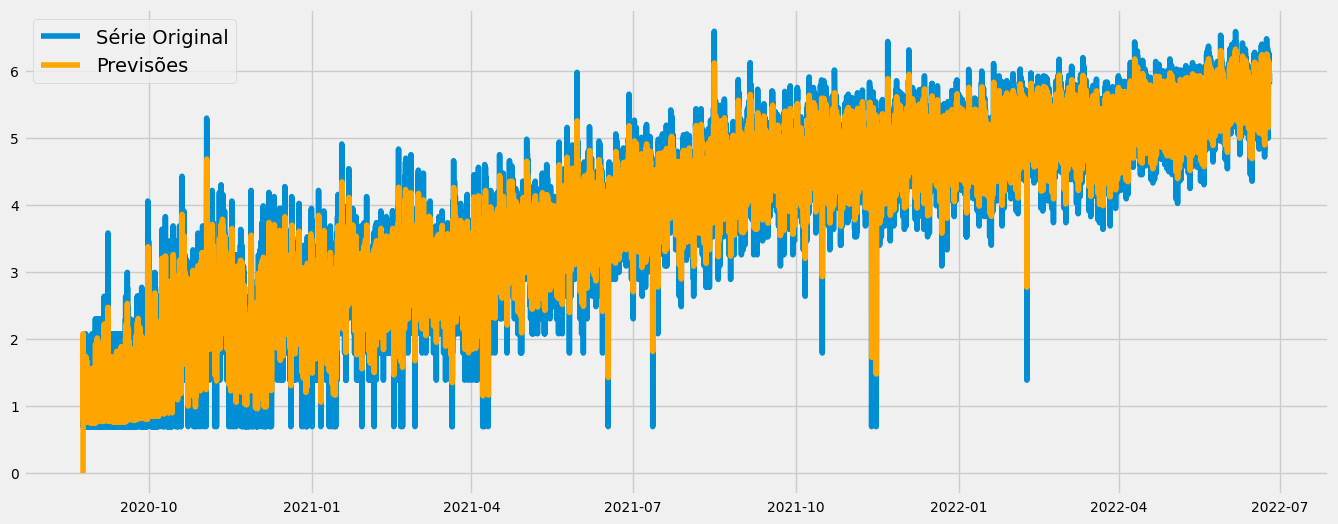

In [25]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [26]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
# usamos a dataset com transformação em log, no treinamento
# Lembrar que não foi usado pra treinar o modelo o df com diferenciação, foi feita pra descobrir os parametros p,d e q!!
df_valid_log = np.log(df_valid['valor_titulo'])

In [27]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes = modelo_v3.forecast(len(df_valid_log), alpha = 0.05) # nivel de significancia = alfa

In [28]:
df_previsoes.shape

(2230,)

In [29]:
# lembrar que os valores estão com trasnformação em log
df_previsoes.tail()

2022-09-25 18:00:00    5.6822
2022-09-25 19:00:00    5.6822
2022-09-25 20:00:00    5.6822
2022-09-25 21:00:00    5.6822
2022-09-25 22:00:00    5.6822
Freq: H, Name: predicted_mean, dtype: float64

In [30]:
# Inversa da transformação de log
np.exp(df_previsoes).tail()

2022-09-25 18:00:00    293.594611
2022-09-25 19:00:00    293.594611
2022-09-25 20:00:00    293.594611
2022-09-25 21:00:00    293.594611
2022-09-25 22:00:00    293.594611
Freq: H, Name: predicted_mean, dtype: float64

In [31]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes, index = df_valid_log.index)

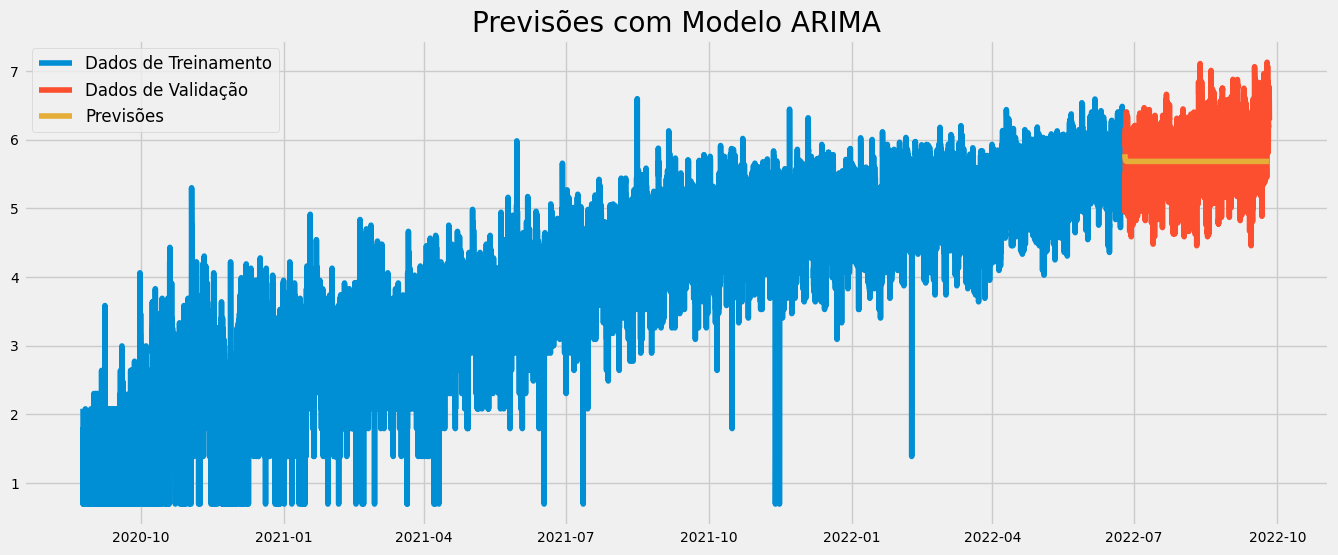

In [32]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série com o modelo criado. Vamos calcular o erro do modelo.

In [33]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [34]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [35]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5396331777537399


Queda do erro foi mto significativa! 